[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/global_modeling.ipynb)

# Global Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

First, we load the data:

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(10)
set_log_level("ERROR", "INFO")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


In [3]:
len(df_ercot['ds'])

154854

We extract the name of the regions which will be later used in the model creation.

In [4]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [5]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[['ds', col]].copy(deep = True) #select column associated with region
    aux = aux.iloc[:26301, :].copy(deep = True) #selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns = {col: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    aux['ID'] = col
    df_global = pd.concat((df_global,aux))

<AxesSubplot:>

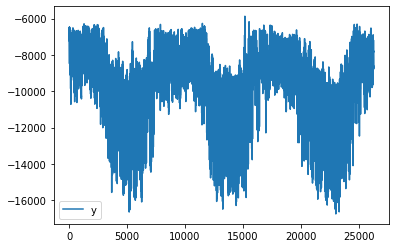

In [6]:
import numpy as np

df_global['y'] = np.where(df_global['ID']=='COAST', -df_global['y'], df_global['y'] )

df_global[df_global['ID']=='COAST'].plot()

When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [7]:
m = NeuralProphet(n_lags = 24)
df_train, df_test = m.split_df(df_global, valid_p = 0.33, local_split = True)

Global modeling lets us train our model based on a global or a local normalization. In the latter, each time series is normalized locally (each time series has its respective data params). In the former, we have unique data params which will be used in all the time series at hand. 

## Global Modeling - Local Normalization

The default fitting of global models is based on local data normalization. Each time series will have data normalization parameters associated with each 'ID' provided. We are going to define a model which predicts the next hour based on the last 24 hours.

In [8]:
m = NeuralProphet( epochs=5, daily_seasonality=False, season_global_local='local')

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

In [9]:
metrics = m.fit(df_train, freq = 'H')

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

In [10]:
m.model.season_params['weekly']

Parameter containing:
tensor([[ 0.0059, -0.0426, -0.0095,  0.0114,  0.0046, -0.0040],
        [-0.0192,  0.0645,  0.0198, -0.0175, -0.0083,  0.0072],
        [-0.0069,  0.0476,  0.0102, -0.0141, -0.0027,  0.0111],
        [-0.0114,  0.0598,  0.0111, -0.0216, -0.0019,  0.0147],
        [-0.0149,  0.0527,  0.0161, -0.0145, -0.0079,  0.0154],
        [-0.0121,  0.0320,  0.0114, -0.0200, -0.0040,  0.0145],
        [-0.0065,  0.0467,  0.0213, -0.0104,  0.0017,  0.0098],
        [-0.0064,  0.0503,  0.0078, -0.0208, -0.0084,  0.0117]],
       requires_grad=True)

In [11]:
m.model.season_params['yearly']

Parameter containing:
tensor([[ 9.4062e-02,  2.2638e-01, -5.2985e-02, -3.5289e-02, -3.9002e-02,
          7.0011e-03,  1.7785e-02,  7.8042e-03, -1.8902e-02, -2.2432e-04,
         -3.5008e-03,  8.1383e-03],
        [-7.9674e-02, -9.9398e-02,  6.5039e-02,  8.5090e-02,  2.2000e-02,
          1.3441e-02, -2.4244e-02,  3.4515e-04, -6.5339e-03, -2.6152e-02,
         -3.0521e-03, -1.3523e-02],
        [-4.1766e-02, -8.2968e-02,  2.6992e-02,  1.1585e-01,  1.5876e-02,
          4.5668e-03, -4.1848e-02,  7.0042e-03, -1.5842e-02, -2.4405e-02,
          1.1105e-02, -1.3912e-02],
        [-8.3601e-02, -9.4504e-02,  7.9166e-02,  1.1766e-01,  1.9316e-02,
          2.4512e-02, -3.2920e-02,  7.3601e-03, -5.0437e-03, -2.7652e-02,
          1.3345e-05, -1.6057e-02],
        [-9.1333e-02, -1.1014e-01,  7.2118e-02,  1.0007e-01,  2.6721e-02,
          1.7879e-02, -3.3751e-02,  3.8737e-03, -1.5879e-02, -2.2743e-02,
         -3.2216e-03, -1.8212e-02],
        [-9.6366e-02, -1.4987e-01,  3.3236e-02,  3.6181e-0

Ensure you provide data identified with the keys associated with the appropriate train time series. Therefore, suitable normalization data parameters are used in post-fitting procedures (i.e., `predict`, `test`).

In [12]:
future = m.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = m.predict(future)


'COAST'

'EAST'

'FAR_WEST'

'NORTH'

'NORTH_C'

'SOUTHERN'

'SOUTH_C'

'WEST'

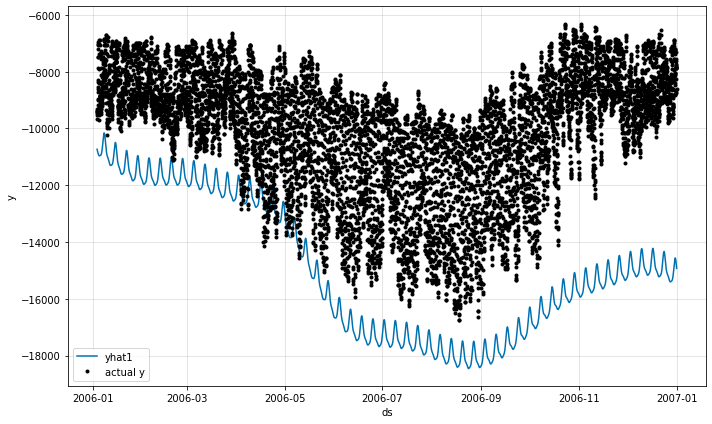

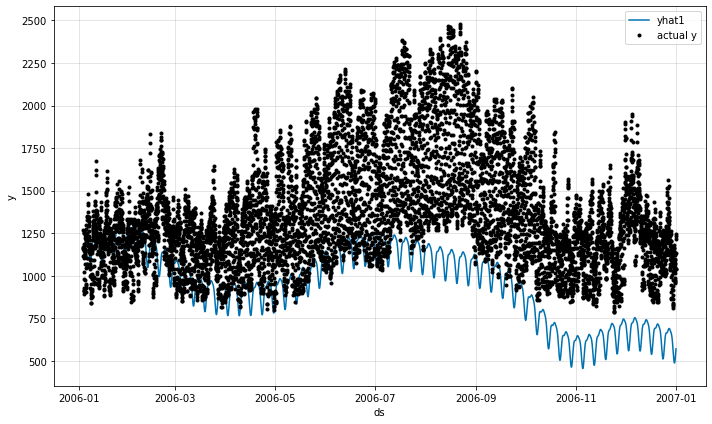

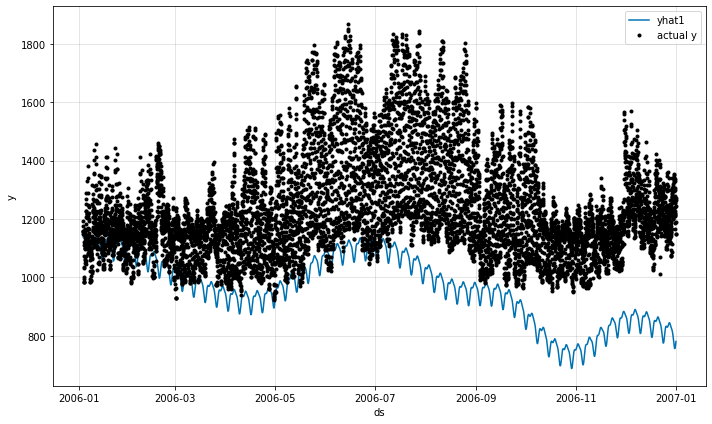

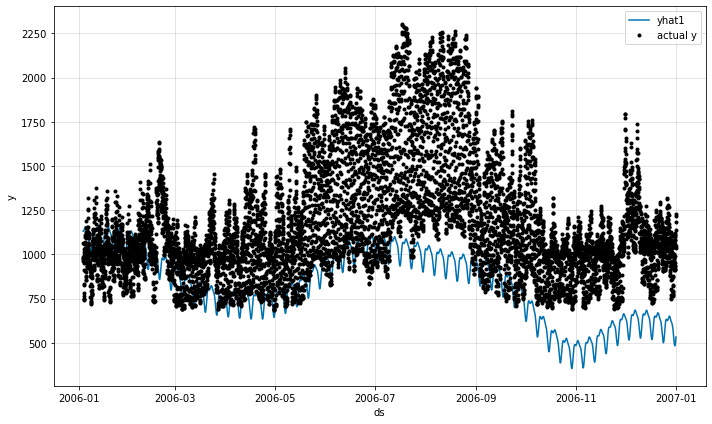

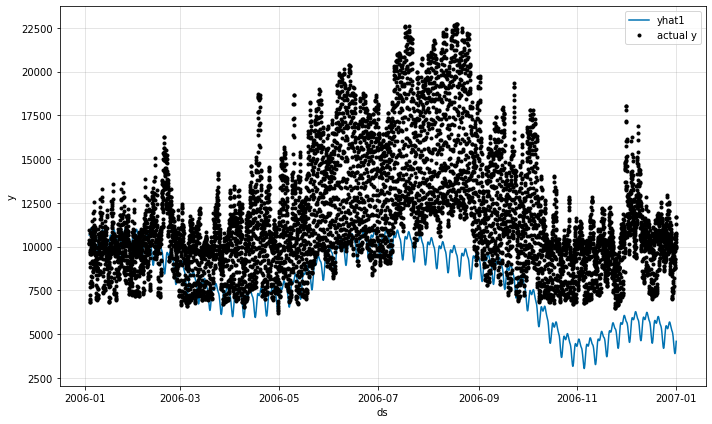

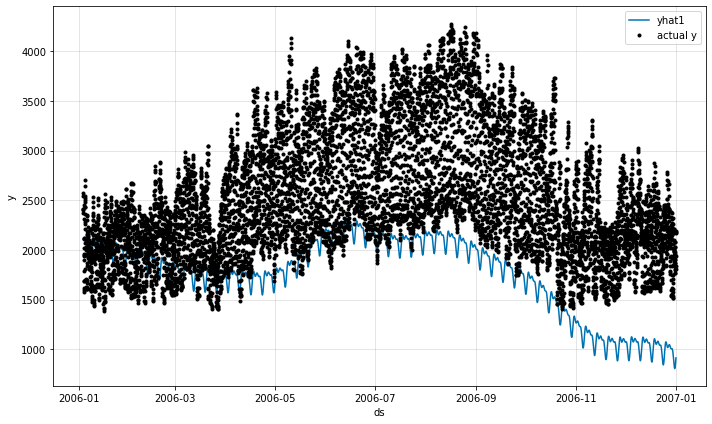

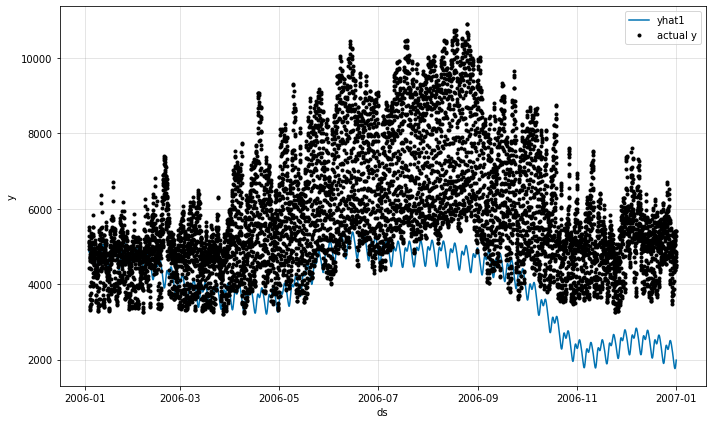

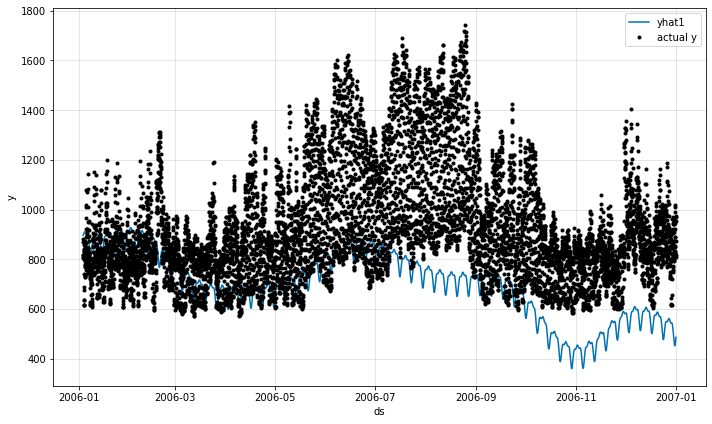

In [13]:
for i in future['ID'].unique():
    display(i)
    fig_glob = m.plot(forecast[forecast['ID'] ==  i])

Please note that in the case of local normalization, the test metrics are not re-scaled but displayed on a normalized scale.

When using local normalization, the data parameters of the test time series may not be known. For example, let's say that hipothetically we just had the data from seven of the regions provided. If we tested the model in a different region, we would not have suitable data params to normalize the data with.

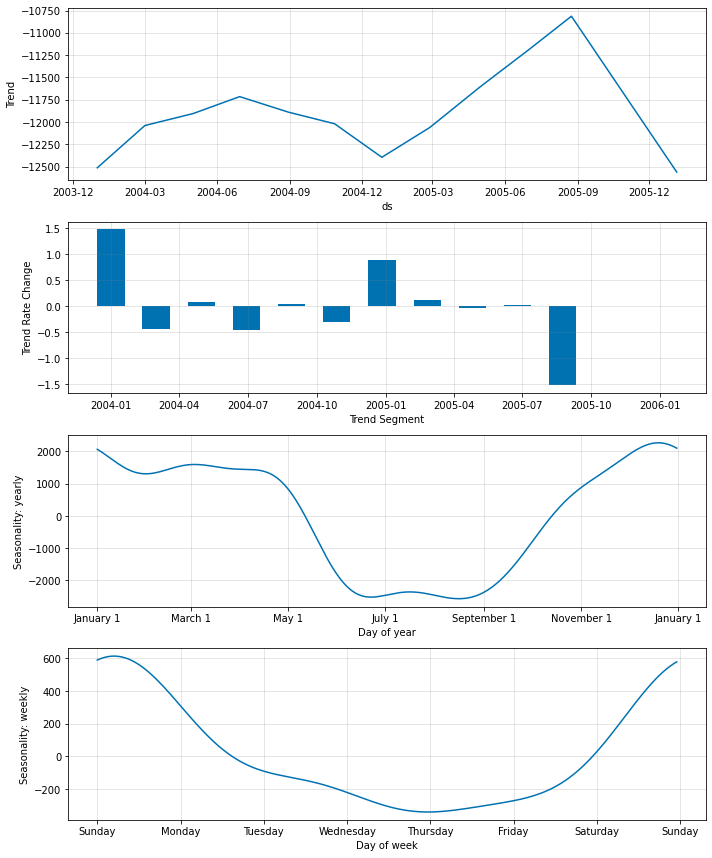

In [15]:
fig_param = m.plot_parameters(df_name='COAST')

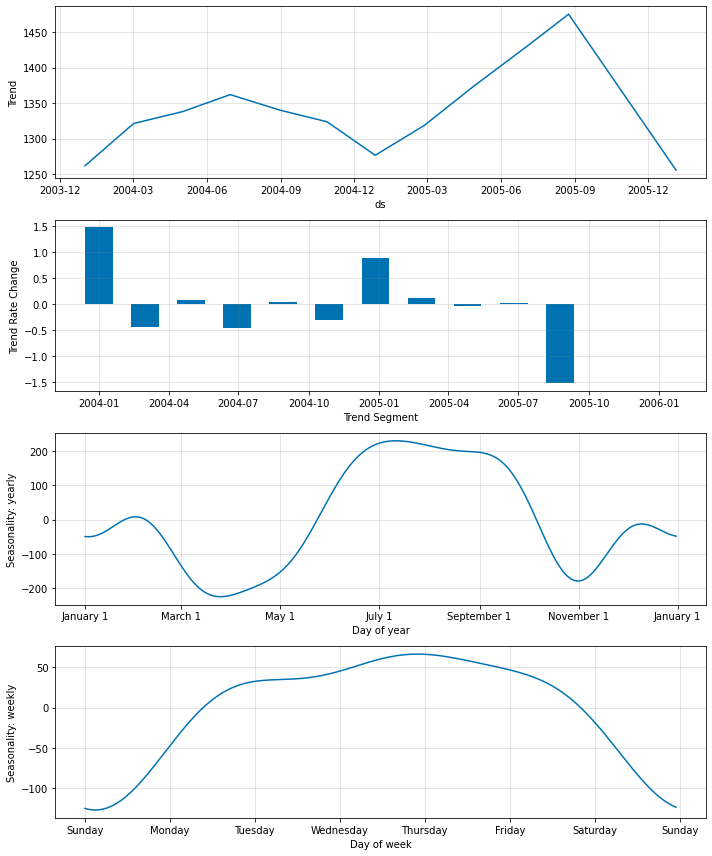

In [16]:
fig_param = m.plot_parameters(df_name='EAST')

In [ ]:
test_metrics = m.test(df_test)
test_metrics

In [ ]:
df_train_no_north = df_train[df_train['ID'] != 'NORTH']
df_test_north = df_test[df_test['ID'] == 'NORTH']

Although 'NORTH' region data may not be used in the training procedure, local normalization can still be used to fit the model. However, the `unknown_data_normalization` input of the `NeuralProphet` object should be set to True. All post-fitting functions will normalize the test data according to global data parameters.

In [ ]:
m = NeuralProphet(n_lags = 24, unknown_data_normalization = True)

In [ ]:
metrics = m.fit(df_train_no_north, freq = 'H')

In [ ]:

future = m.make_future_dataframe(df_test_north, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast)

## Global Modeling - Global Normalization

In some cases, the global model may be fitted on data that is globally normalized. In this case, the user should set `global_normalization` to True when instantiating the `NeuralProphet` forecaster. When using global modeling global normalization, the 'ID' of the provided df either for train or test data are ignored. 


In [14]:
m = NeuralProphet(n_lags = 24, global_normalization = True)
metrics = m.fit(df_train)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

We can visualize the parameters of the trained models.

We can evaluate the test metrics considering time series from all regions.

In [16]:
test_metrics = m.test(df_test)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.000042,63.647886,87.056988


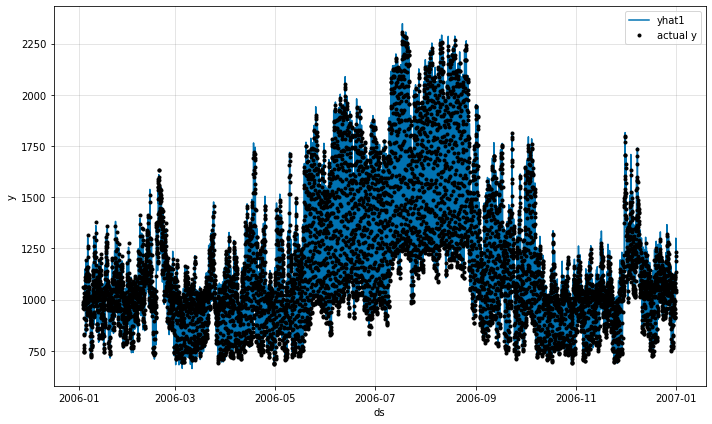

In [17]:
future = m.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast, df_name='NORTH')